# Kono - Github repo health data analyses

## Overview

My initial project at Red Hat was to pursue a means for assessing the health of a github project. It was envisaged that if project health metrics were established, these could enable determining insights not readily apparent by github's extant visualizations and features (e.g. repo graphs, pulse)  As a nascent member of the Emerging technology group at Red Hat, it was paramount my initial work also provide a means for getting familiar with, and learning the benefits of the tooling within our group as pertains to big data products. During the project's inception, this primarily was within the [radanalyticsio](http://radanalytics.io) body of work which provides integration advantages of both [OpenShift](https://www.openshift.com/) for containerization of applications and Spark for scalable computation. With this in mind, in this article, I shall describe my journey with this project up to present.


## Related Work

While graduate school is blissfully far behind me, I would be remiss if I omitted details of what I consider a salient feature of any project undertaken: background checks. Call it a literature search, call it a prior art search, or call it creeping for info, it's a must to be certain one is not reinventing the wheel or stepping on anyone's legal toes. Particularly when embarking on a career with the world's leading provider of open source solutions as in my case, there's no excuse for a lack of due diligence. Looking over the landscape of github repo data projects, the following stood out:

- [githut](http://githut.info/) is a project which gives a quarterly data on repository languages based on pushes. 

- [github-statistics](https://github.com/AndrewVos/github-statistics) pursued relationships between profanity in commit messages and project activity.

- [open source monthly](http://alysonla.github.io/open-source-monthly/) Tableau Public workbook connected to BigQuery. Shows type of events and activity per login.

- [octoboard](https://github.com/KuiKui/Octoboard) repo's referred URL is now a product site  for a BI dashboard. Uncertain if related, Octoboard was originally name of a github data challenge project. Shows timeline API activity.

- [GDC2](https://github.com/davidfischer/gdc2) geographic info for github repos. Pulls data files, massages, ranks by quanitity of repos in region.

- [Open Source Report Card](https://github.com/dfm/osrc) open source report card, uses deprecated API. Became Gild, which is now 404. 

This said to me that the work I had in mind was novel in that it could provide a means for insights not currently possible, along with the novelty of taking advantage of OpenShift and Spark.

## Available Data

In the same vein as checking out extant work, I next needed to understand what github repo data would be available. I prefer to see what I have to work with before embarking on feature engineering or otherwise. This again goes back to not reinventing the wheel, with the potential benefit of building off existing datasets and sources. 

### Sources

- github provides a [REST API](https://developer.github.com/v3/) for retrieving repo data. As one would expect, rate limitations are in place. The API permits checking for updates via a lightweight API call.

- [githubarchive](https://www.githubarchive.org) provides GZip compressed JSON files, each containing an hour of github event data.

- BigQuery provides a githubachive-based dataset [found here](https://cloud.google.com/bigquery/public-data/github). 

### Structure

- Events as defined in the [github event API docs](https://developer.github.com/v3/activity/events/types) are available using all aforementioned sources.

- Non-event data (e.g. repo, org, user details) is available from the github API, depending on privacy settings.


## Derived Repo Health Metrics

Having an understanding of the data sources and availability, my next step was to consider what metrics would be appropriate in assessing the health of a project/repo, in data science-ish terms, this approaches feature engineering, but not quite. Put more simply, what makes a healthy repository? With this in mind, I assembled the following areas of interest with associated metrics I considered feasible:

- **Activity** - A healthy repository does not have tumbleweeds blowing through it. Even projects in maintenance will have just that, maintenance events. As such, a general sum of events broken down by type would be useful.

- **Interest** - A healthy repository inspires others to engage in what's provided. As such, data on number of the number of forks generated would be useful. As well as pull requests, issues, and comments. 

- **Responsiveness** - A good repository needs an owner/maintainer or group of such who, as needed, responds to communications from the community. Hence, another metric to consider is the response time in addressing pull requests and issues. 

- **Contributor Demeanor** - In my experience, the language one uses in their commit messages can be indicative of the contributor's mindset. For example, a disgruntled contributor might show up in [this project's](http://andrewvos.com/2011/02/21/amount-of-profanity-in-git-commit-messages-per-programming-language) radar. On the other end of the spectrum, commit messages with an excess of emoticons and effusiveness could betray a lack of seriousness about their craft. So sentiment analysis of commit messages in a repo could also be of value. As an aside, this metric resides in waters which can be tough to tread, since one might argue the commit language does not impact the efficacy of the contribution, however its exploring these fuzzy areas that are part of what makes what I do so much fun! 

- **Starring** - I am listing these as their own point, since the subjectiveness of starring is apparent. Standalone studies of correlations between starring and more quantitative metrics would be a subject unto themselves.


## Data Acquisition Approach

Given the metrics of interest, and what data sources are available, it was time to consider how I wanted to tackle this. First, this table indicates what I considered the advantages/disadvantages of the aforementioned sources:

| Source          | Advantage              | Disadvantage                                       |
| :-------------- | :--------------------- | :------------------------------------------------- |
| github API      | Direct from github     | Rate limited                                       |
| github archive  | No rate limit          | Requires initial download investment               |
| BigQuery        | Query driven interface | No 2017 data, analysis amount limited in free tier |

In my case, I wanted to be able to play with the data, making ~~some~~ many exploratory queries that lead to dead ends, back tracking as needed. As a result, the github API data and BigQuery usage limitations were not appealing. Since summary information is available in github's state of the Octoverse up to 2016 [articles](https://octoverse.github.com/) I chose to focus on data from Q1 2017. So, I began with this command to acquire the data files (note: this will download a large amount of data.)


In [1]:
! mkdir -p ./data/2017
! wget -q -N http://data.githubarchive.org/2017-{01..03}-{01..31}-{0..23}.json.gz -P ./data/2017
! echo "Download complete"

## Scalability Preparation

As mentioned, this is a large amount of data: hundreds of files for this quarter alone. I needed a means for processing this data in a parallel manner. Splitting each file into its own task seemed reasonable, since each record within the file has a timestamp. Looking further down the line, it seemed prudent (and useful for my project) if this work would be containerized as well. As a result, I pursued implementation in an OpenShift environment using a Docker image providing a means for utilizing pyspark-enabled Jupyter notebooks. This image was developed by members of the radanalytics community, at that! More info about it lives [here](https://hub.docker.com/r/radanalyticsio/base-notebook/). The instructions to get this up and running on one's local machine are fiendishly simple, and are as follows:

1. Install OpenShift origin using 
```bash 
dnf install origin
``` 
for Fedora or 
```bash
brew install minishift
``` 
for OSX (you **are** using Homebrew, right?). Windows folks, you're on your own here. 

2. From a terminal, type 
```bash
oc cluster up 
```
or 
```bash
minishift start
```
for Linux or OSX, respectively. An OpenShift instance will be started on your local machine. 

3. You'll get a message with a url for connecting to the OpenShift web UI, browse to that using your browser of choice. For example, the following:

 The server is accessible via web console at:
       https://127.0.0.1:8443

4. Your browser may complain about this connection being unsafe, make quick work of that and move on.

5. By default, an account with credentials developer/developer is created. Log in with these. 

6. By default, a project is created called MyProject, it will get the job done for most basic trying out needs. Click on it. 

7. Click add to project. 

8. Choose the Deploy Image tab. 

9. Select the Image Name radio button and type radanalyticsio/base-notebook, hit enter. 

10. To make life easier environment variables can be set for the Jupyter notebook settings, so that a password is used instead of a token. For example, JUPYTER_NOTEBOOK_PASSWORD can be set to NePtune.

11. Click create.

12. From the command line, type oc expose svc/base-notebook (Note: this can also be done via the web UI but I like the command line) 

13. Back to the web UI, there should be a URL for the route just exposed, this will lead to the PySpark Jupyter notebook goodness. 

14. Oho! It wants a password! Type in whatever was set previously for JUPYTER_NOTEBOOK_PASSWORD. Did you neglect to do this? Have no fear, there is another approach:

- Click on the 1 pod text with a circle around it, then click the terminal tab. 
- Following the instructions shown on the Jupyter URL you navigated to, type jupyter notebook list, copy what's output as the token, and paste into the password entry box of the Jupyter URL. 

15. Now for the real fun, upload your Jupyter notebook or start a new one and jam.

Having the base-notebook image in place is a huge convenience. However, it may not include some of the packages needed depending on application. As I learned, it's possible to install them locally within the cluster using Jupyter's bash magic commands as follows (Note: this could also be done via the terminal tab of the pod)

In [2]:
! pip install --user --quiet nltk
! pip install --user --quiet vaderSentiment

Of course, a Docker image could also be created that includes the necessary libraries, but this local method worked for me. Path of least resistance is my bff. 

## Metric Implementations and Visualizations

So I started with some imports (I'm cheating and including everything I now know I need but these imports could be placed in as needed locations) and set up a SparkSession and context. Note the need to add the local packages, which live in site-packages, it's complicated, to the system path. Further note this image is Python 2.7 so prepare accordingly _vis a vis_ future print.

In [52]:
%matplotlib inline
import re
import json
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import sys,os,os.path
import math
from matplotlib.ticker import MaxNLocator
from pyspark.sql import SparkSession
sys.path.append(os.path.expanduser('~/.local/lib/python2.7/site-packages'))
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pyspark.sql import Row


spark = SparkSession\
        .builder\
        .config("spark.executor.heartbeatInterval","3600s")\
        .appName("kono")\
        .getOrCreate()

sc = spark.sparkContext

### Activity via Number of Events

Finally, I could do my first metric calculation! For a given repo URL (kubernetes/kubernetes in this example), I parsed the repo name, then start working through the data files to get all event instances. Due to differences in key names between event types, having only the name of the repo was insufficient, as a result, I call out to the github API just once to get the repo's internal ID which **is** universal across event records:

In [53]:
repoURL = 'https://github.com/kubernetes/kubernetes'
repoFullName = repoURL.split('github.com/')[-1]

repoAPIURL = 'https://api.github.com/repos/' + repoFullName
repoID = requests.get(repoAPIURL).json()['id']

inFiles = "data/2017/2017*.json.gz"

eventRecords = sc.textFile(inFiles)\
            .map(lambda record: json.loads(record))\
            .filter(lambda record: record['repo']['id'] == repoID)\
            .cache()
            
eventCounts = eventRecords.map(lambda record: (record['type'],1))\
         .reduceByKey(lambda a, b: a+b)\
         .collect()

Next I converted the event records to a Pandas dataframe, get the count of each record type, and massage the event type names to render a prettier bar plot in Seaborn.

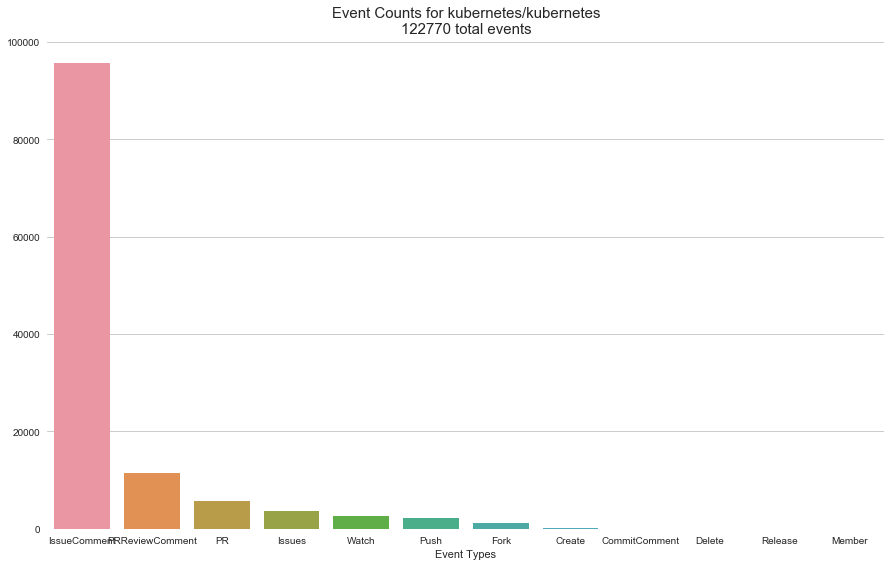

In [54]:
sns.set_style("whitegrid")
f, ax = plt.subplots(figsize=[15,9])
prettyCounts = sorted([ (re.sub(r'Event',r'',rec[0]),rec[1]) for rec in eventCounts ],key=lambda rec: rec[1],reverse=True)
prettyCounts = [ (re.sub(r'PullRequest',r'PR', rec[0]),rec[1]) for rec in prettyCounts ]
yVals = [ rec[1] for rec in prettyCounts ]
xVals = [ rec[0] for rec in prettyCounts ]
sns.barplot(y=yVals ,x=xVals)
plt.title('Event Counts for ' + repoFullName +'\n'+str(sum(yVals))+' total events',fontsize=15)
ax.set(ylabel="",
       xlabel="Event Types")
sns.despine(left=True, bottom=True)

### Responsivness
GitHub's record timestaps are in the format YYYY-mm-ddThh:mm:ssZ, the following gives a means for parsing timestamps and returning resolution time in days.
 

In [55]:
timeStampFormat = '%Y-%m-%dT%H:%M:%SZ'

def parseGitHubUTCTimeStamp(ts):
    return dt.datetime.strptime(ts, timeStampFormat)

def determineResolutionTime(opened,closed):
    td = closed - opened 
    return abs(td.days)

#### Issue Resolution Time
For a given repo issue, I determined delta between issue posted and issue resolved.


In [56]:
def parseIssuesRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    issueID = record['payload']['issue']['id']
    action = record['payload']['action']
    return [issueID, [action, timeStamp]]

issuesRecords = eventRecords\
        .filter(lambda record: record['type'] == 'IssuesEvent')

openedRecords = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
timesToCloseIssues = issuesRecords\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda issuesRecord: parseIssuesRecord(issuesRecord))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>2)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][3]))\
        .collect()

And then I made another Seaborn plot, in this case I did a histogram of the number of days between issue creation and closing. 

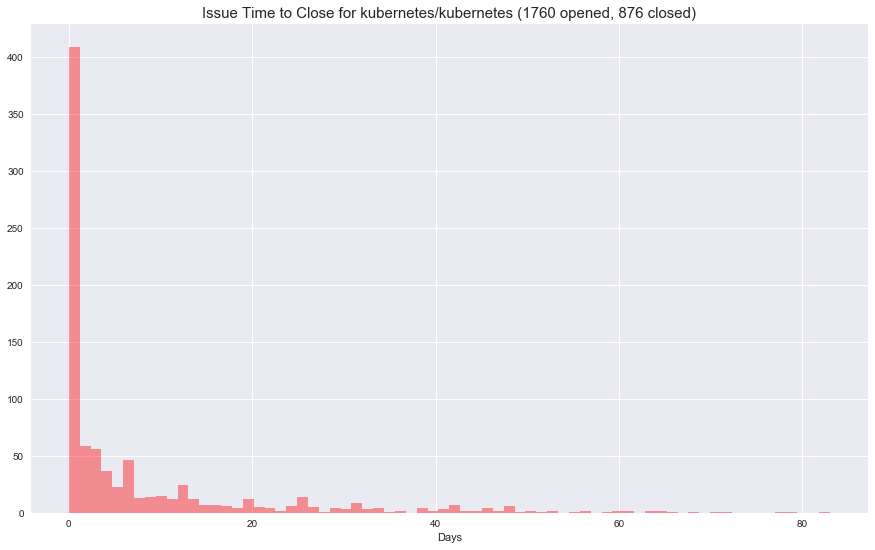

In [57]:
sns.set()
bx = plt.figure(figsize=[15,9]).gca() 

sns.distplot(timesToCloseIssues,\
             kde=False,bins=70,color='red')
titleStr=('Issue Time to Close for ' + repoFullName + ' (' + str(openedRecords) + ' opened, ' + str(len(timesToCloseIssues)) + ' closed)')
bx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
bx.yaxis.set_major_locator(MaxNLocator(integer=True))


#### Pull Request Close Time

For a given repo, I determined the delta between pull request opening and closing. 

In [58]:
def parsePullRequestRecord(record):
    timeStamp = parseGitHubUTCTimeStamp(record['created_at'])
    pullRequestID = record['payload']['pull_request']['id']
    action = record['payload']['action']
    merged = record['payload']['pull_request']['merged']
    return [pullRequestID, [action, timeStamp, merged]]

pullRequests = eventRecords\
        .filter(lambda record: record['type'] == 'PullRequestEvent')

openedPullRequests = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened')\
        .count()
    
    
timesToClosePulls = pullRequests\
        .filter(lambda record: record['payload']['action'] == 'opened' or record['payload']['action'] == 'closed')\
        .map(lambda record: parsePullRequestRecord(record))\
        .reduceByKey(lambda a,b: a+b)\
        .filter(lambda rec: len(rec[1])>3)\
        .map(lambda rec: determineResolutionTime(rec[1][1],rec[1][4]))\
        .collect()
        

I used Seaborn once again to create a histogram of the times. 

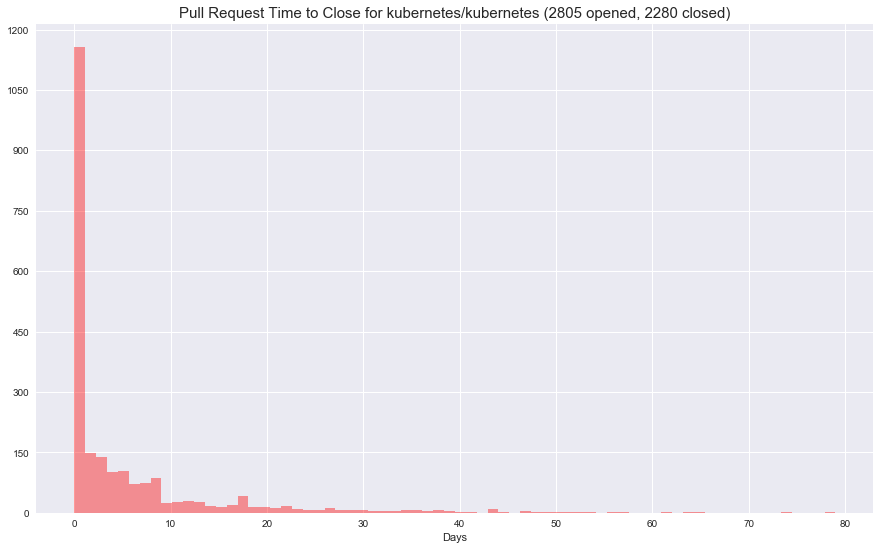

In [59]:
sns.set()
cx = plt.figure(figsize=[15,9]).gca() 

sns.distplot(timesToClosePulls,\
             kde=False,bins=70,color='red')
titleStr=('Pull Request Time to Close for ' + repoFullName + ' (' + str(openedPullRequests) + ' opened, ' + str(len(timesToClosePulls)) + ' closed)')
cx.set(ylabel="",xlabel="Days")
plt.title(titleStr,fontsize=15)
cx.yaxis.set_major_locator(MaxNLocator(integer=True))


### Sentiments

After some digging around for extant libraries, I determined I would get sentiment intensity values using the [Vader Sentiment](https://github.com/cjhutto/vaderSentiment) package. For an input string, values ranging from 0-1 are output for positive, neutral, and negative sentiments, as well as a composite sentiment based on the three intensities. Per vader's docs, I created an instance of the sentiment analyzer to be used throughout my sentiment metrics. I also made a function to determine sentiments and return a dataframe friendly result. For each message, vader is used to determine its intensity triplet, from which the mean of all three valences is computed. Finally, the percentage each sentiment type contributed to the total sentiment is computed.

In [60]:
analyzer = SentimentIntensityAnalyzer()

def determineSentiments(messages, mType):
    neg=0
    pos=0
    neu=0
    numMessages=0
    
    for m in messages:
        numMessages+=1
        scores=analyzer.polarity_scores(m)
        neg+=scores['neg']
        pos+=scores['pos']
        neu+=scores['neu']
            
    if(numMessages > 0):
        neg/=numMessages
        pos/=numMessages
        neu/=numMessages
        total = neg+pos+neu
        neg = neg*100/total
        pos = pos*100/total
        neu = neu*100/total
        
    ret = [{'MessageType': mType, 'SentimentType': 'Positive', 'Value': pos},\
           {'MessageType': mType, 'SentimentType': 'Neutral', 'Value': neu},\
           {'MessageType': mType, 'SentimentType': 'Negative', 'Value': neg}]
    
    return ret

#### Commit Messages
PushEvent records may have multiple commits, each of which has its own message. As will be seen, IssueCommentEvent and PullRequestReviewEvent records have a single message. In order to comply with the above defined function, the commit messages are extracted from the PushEvent records. 


In [61]:
commitMessages = eventRecords\
        .filter(lambda record: record['type'] == 'PushEvent')\
        .flatMap(lambda record: record['payload']['commits'])\
        .map(lambda record: record['message'])\
        .collect()

commitMessageSentiments = determineSentiments(commitMessages,'Commit') 

#### Issue Comments

For each issue comment, I again checked the sentiment percentages as per the commit messages.

In [62]:
issueCommentBodies = eventRecords\
        .filter(lambda record: record['type'] == 'IssueCommentEvent')\
        .map(lambda record: record['payload']['comment']['body'])\
        .collect()

issueMessageSentiments = determineSentiments(issueCommentBodies, 'Issue')

#### Pull Request Review Comments

For each pull request review comment, I checked the sentiment percentages, and finally plotted the sentiment percentages making up each of the three types of comments.

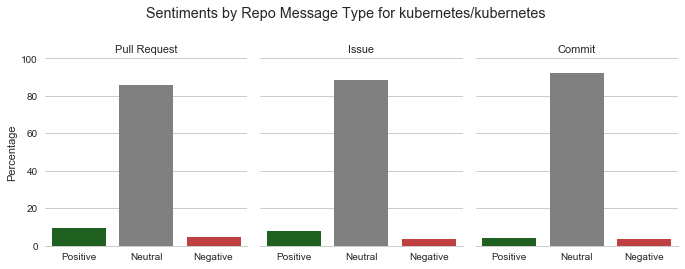

In [63]:
pullRequestReviewCommentRecords = eventRecords\
        .filter(lambda record: record['type'] == 'PullRequestReviewCommentEvent')\
        .map(lambda record: record['payload']['comment']['body'])\
        .collect()

pullRequestMessageSentiments = determineSentiments(pullRequestReviewCommentRecords, 'Pull Request')

sdf = pd.DataFrame(pullRequestMessageSentiments)\
    .append(issueMessageSentiments,ignore_index=True)\
    .append(commitMessageSentiments,ignore_index=True)
    
sns.set_style("whitegrid")
pal = dict(Positive="Green",Neutral="Gray",Negative="Red")
g = sns.factorplot(x="SentimentType",y="Value",col="MessageType",\
                    data=sdf,kind="bar", ci=None,\
                    palette=pal,saturation=0.5, aspect=0.8)

g=g.set_axis_labels("", "Percentage")\
        .set(ylim=(0, 100))\
        .set_titles("{col_name}")\
        .despine(left=True)

plt.subplots_adjust(top=0.8)
g=g.fig.suptitle("Sentiments by Repo Message Type for " + repoFullName)

## Lessons Learned

In each case, OpenShift with the radanalyticsio base-notebook image made life much easier. Further, what I presented here only scratches the surface of what's enabled. I could have generated a Dockerfile with the packages I needed, delved into the mystic art of continuous integration with my notebook's repo, added a caching layer whereby results from processing github log files was stored. API result calls could be cached similarly. 

In previous work I relied on grabbing resources with perhaps reckless abandon, at times in the interest of working with a resource-constrained target (e.g. a ton of AWS space for crunching data to derive optimal parameters for a minimal algorithm mapped to an MCU). This project elucidated challenges beyond the target hardware, indeed the compute resources were constrained. It's true, BigQuery data with its associated GCE costs would have provided a less bandwidth spent on initial log file pulls. However, reliance on another platform was not an option, and indeed this constraint enabled my determining a novel means for achieving my goals.
